# Backtest: validation on historical data

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of time series validation using backtest module of ETNA library.

**Table of Contents**

* [What is backtest and how it works](#chapter1)  
* [How to run a validation](#chapter2)
* [Validation visualisation](#chapter3)
* [Metrics visualisation](#chapter4)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.pipeline import Pipeline
from etna.models import CatBoostModelMultiSegment
from etna.analysis.plotters import plot_backtest
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TrendTransform

/home/ext.ytarasyuk/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


### 1. What is backtest and how it works <a class="anchor" id="chapter1"></a>

Backtest is a predictions and validation pipeline build on historical data to make a legitimate retrotest of your model.

<b>How does it work?</b>

When constructing a forecast using Models and further evaluating the prediction metrics, we measure the quality at one time interval, designated as test.

Backtest allows you to simulate how the model would work in the past:

* selects a period of time in the past

* builds a model using the selected interval as a training sample

* predicts the value on the test interval and calculates metrics.

The image shows a plot of the backtest pipeline with `n_folds = 3`.

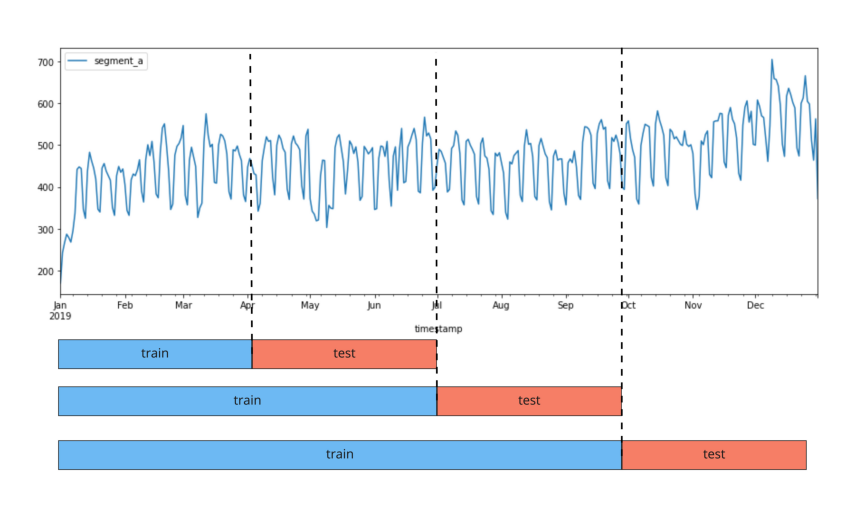

In [2]:
img = plt.imread("./assets/backtest/backtest.jpg")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

Below we will call a fold the train + test pair, for which training and forecasting is performed.

In [3]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


In [4]:
df.tail()

,timestamp,segment,target
329,2019-11-26,segment_a,591
330,2019-11-27,segment_a,606
331,2019-11-28,segment_a,555
332,2019-11-29,segment_a,581
333,2019-11-30,segment_a,502


Our library works with the spacial data structure TSDataset. So, before starting the EDA, we need to convert the classical DataFrame to TSDataset.

In [5]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

#### Let's get a look on series

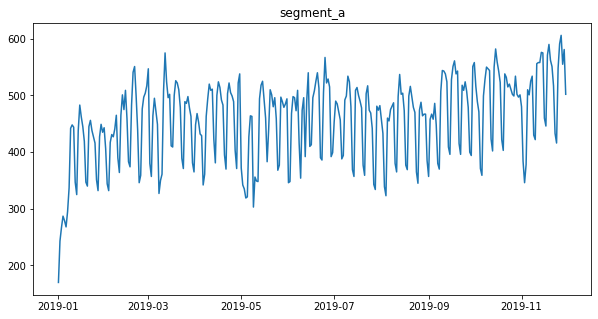

In [6]:
ts.plot(segments=["segment_a"])

### 2. How to run a validation <a class="anchor" id="chapter2"></a>

For an easy start let's create a CatBoost model

In [7]:
horizon = 31  # Set the horizon for predictions
model = CatBoostModelMultiSegment()  # Create a model
transforms = [
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=list(range(horizon, horizon+50)), out_column="target_lag"),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=True,week_number_in_month=True, out_column="date_flag"),
    SegmentEncoderTransform(),
]  # A list of transforms

### `Pipeline` <a class="anchor" id="section_2_1"></a>

Now let's create an instance of `Pipeline`.

In [8]:
pipeline = Pipeline(model=model, transforms=transforms, horizon=horizon)

We are going to run `backtest` method for it. As a result, three dataframes will be returned: 
* dataframe with metrics for each fold and each segment, 
* dataframe with predictions, 
* dataframe with information about folds.

In [9]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.0s finished


In [10]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,38.776928,2305.955141,8.668549,0
0,segment_a,20.205963,609.768994,4.671017,1
0,segment_a,19.341381,584.297331,4.007078,2
0,segment_a,22.129986,1051.945122,4.587012,3
0,segment_a,26.349798,1472.620442,5.400758,4


In [11]:
forecast_df.head()

segment                                                                                                                                                                                          segment_a  \
feature    TrendTransform(in_column = 'target', out_column = None, detrend_model = LinearRegression(), model = 'ar', custom_cost = None, min_size = 2, jump = 1, n_bkps = 5, pen = None, epsilon = None, )   
timestamp                                                                                                                                                                                                    
2019-06-29                                           0.912426                                                                                                                                                
2019-06-30                                           0.998295                                                                                                                                                
2019-07-01                                           1.084165                                                                                                                                                
2019-07-02                                           1.170034                                                                                                                                                
2019-07-03                                           1.255904                                                                                                                                                

segment                                                                \
feature    date_flag_day_number_in_month date_flag_day_number_in_week   
timestamp                                                               
2019-06-29                            29                            5   
2019-06-30                            30                            6   
2019-07-01                             1                            0   
2019-07-02                             2                            1   
2019-07-03                             3                            2   

segment                                                                      \
feature    date_flag_is_weekend date_flag_week_number_in_month segment_code   
timestamp                                                                     
2019-06-29                 True                              5            0   
2019-06-30                 True                              5            0   
2019-07-01                False                              1            0   
2019-07-02                False                              1            0   
2019-07-03                False                              1            0   

segment                                                           ...  \
feature         target target_lag_31 target_lag_32 target_lag_33  ...   
timestamp                                                         ...   
2019-06-29  418.125761     11.718785     22.204377     30.689969  ...   
2019-06-30  419.264062     17.233193     11.718785     22.204377  ...   
2019-07-01  494.685413     25.747601     17.233193     11.718785  ...   
2019-07-02  502.734522   -122.737991     25.747601     17.233193  ...   
2019-07-03  473.647550   -121.223583   -122.737991     25.747601  ...   

segment                                                             \
feature    target_lag_72 target_lag_73 target_lag_74 target_lag_75   
timestamp                                                            
2019-06-29     44.628059     67.113651     77.599243     54.084835   
2019-06-30     35.142466     44.628059     67.113651     77.599243   
2019-07-01    -53.343126     35.142466     44.628059     67.113651   
2019-07-02    -78.828718    -53.343126     35.142466     44.628059   
2019-07-03     53.685690    -78.828718    -53.343126     3

In [12]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


You can additionally get the metrics averaged over folds:

In [13]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   53.3s finished


In [14]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,25.360811,1204.917406,5.466883


In [15]:
forecast_df.head()

segment                                                                                                                                                                                          segment_a  \
feature    TrendTransform(in_column = 'target', out_column = None, detrend_model = LinearRegression(), model = 'ar', custom_cost = None, min_size = 2, jump = 1, n_bkps = 5, pen = None, epsilon = None, )   
timestamp                                                                                                                                                                                                    
2019-06-29                                           0.912426                                                                                                                                                
2019-06-30                                           0.998295                                                                                                                                                
2019-07-01                                           1.084165                                                                                                                                                
2019-07-02                                           1.170034                                                                                                                                                
2019-07-03                                           1.255904                                                                                                                                                

segment                                                                \
feature    date_flag_day_number_in_month date_flag_day_number_in_week   
timestamp                                                               
2019-06-29                            29                            5   
2019-06-30                            30                            6   
2019-07-01                             1                            0   
2019-07-02                             2                            1   
2019-07-03                             3                            2   

segment                                                                      \
feature    date_flag_is_weekend date_flag_week_number_in_month segment_code   
timestamp                                                                     
2019-06-29                 True                              5            0   
2019-06-30                 True                              5            0   
2019-07-01                False                              1            0   
2019-07-02                False                              1            0   
2019-07-03                False                              1            0   

segment                                                           ...  \
feature         target target_lag_31 target_lag_32 target_lag_33  ...   
timestamp                                                         ...   
2019-06-29  418.125761     11.718785     22.204377     30.689969  ...   
2019-06-30  419.264062     17.233193     11.718785     22.204377  ...   
2019-07-01  494.685413     25.747601     17.233193     11.718785  ...   
2019-07-02  502.734522   -122.737991     25.747601     17.233193  ...   
2019-07-03  473.647550   -121.223583   -122.737991     25.747601  ...   

segment                                                             \
feature    target_lag_72 target_lag_73 target_lag_74 target_lag_75   
timestamp                                                            
2019-06-29     44.628059     67.113651     77.599243     54.084835   
2019-06-30     35.142466     44.628059     67.113651     77.599243   
2019-07-01    -53.343126     35.142466     44.628059     67.113651   
2019-07-02    -78.828718    -53.343126     35.142466     44.628059   
2019-07-03     53.685690    -78.828718    -53.343126     3

In [16]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


You can also set the folds you need to the backtest using FoldMask.
Consider an example of using FoldMask.

In [17]:
from etna.pipeline import FoldMask
import numpy as np

In [18]:
mask = FoldMask(
    first_train_timestamp=ts.index.min(),
    last_train_timestamp=ts.index.min() + np.timedelta64(120, "D"),
    target_timestamps=pd.date_range(start=ts.index.min() + np.timedelta64(121, "D"), periods=horizon)
    )

In [19]:
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


In [20]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,55.715037,5079.95202,13.237733,0


### 3. Validation visualisation <a class="anchor" id="chapter3"></a>

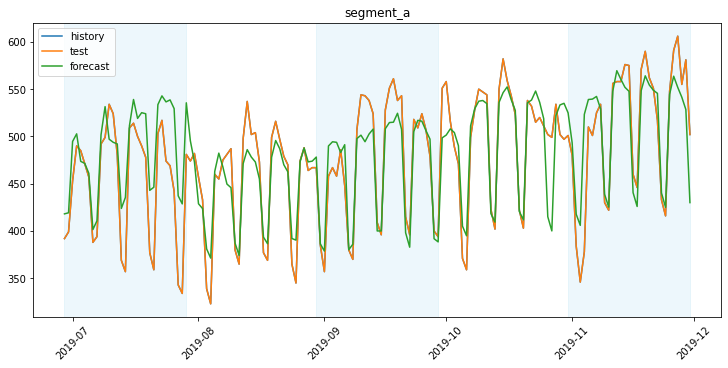

In [21]:
plot_backtest(forecast_df, ts)

Let's see how the data looked before the backtest -  we specify `history_len`.

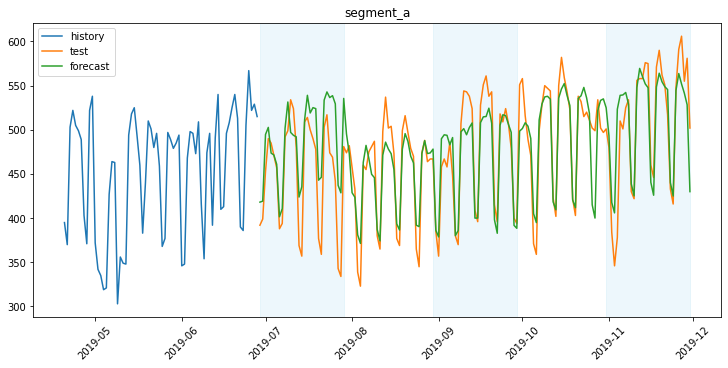

In [22]:
plot_backtest(forecast_df, ts, history_len=70)

### 4. Metrics visualization  <a class="anchor" id="chapter4"></a>

Now let's run backtest on all segments and look metrics

In [23]:
from etna.analysis import metric_per_segment_distribution_plot, plot_residuals, \
    plot_metric_per_segment,prediction_actual_scatter_plot

In [24]:
df = pd.read_csv("./data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts_all = TSDataset(df, freq="D")

In [25]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   55.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


Let's look at the distribution of the SMAPE metric by folds. You can set `type_plot` as `box`, `violin` or `hist`.

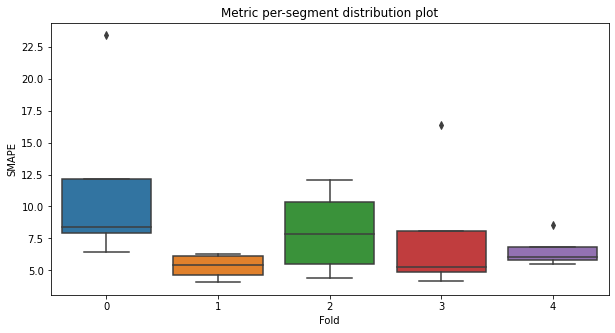

In [26]:
metric_per_segment_distribution_plot(metrics_df=metrics_df, metric_name="SMAPE", plot_type="box")

Let's look at the SMAPE metric by segments

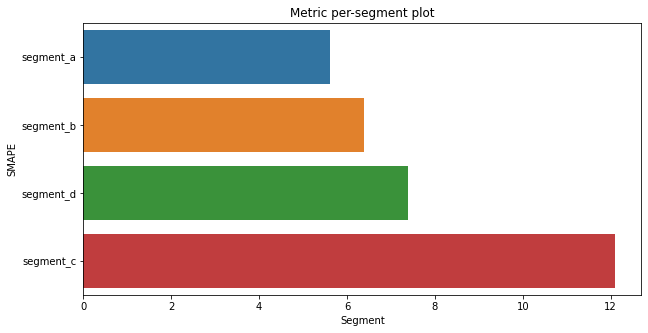

In [27]:
plot_metric_per_segment(metrics_df=metrics_df, metric_name="SMAPE", ascending=True)

Now let's look at the residuals of the model predictions from the backtest. Analysis of the residuals can help establish a dependency in the data that our model could not find. This way we can add features or improve the model or make sure that there is no dependency in the residuals.

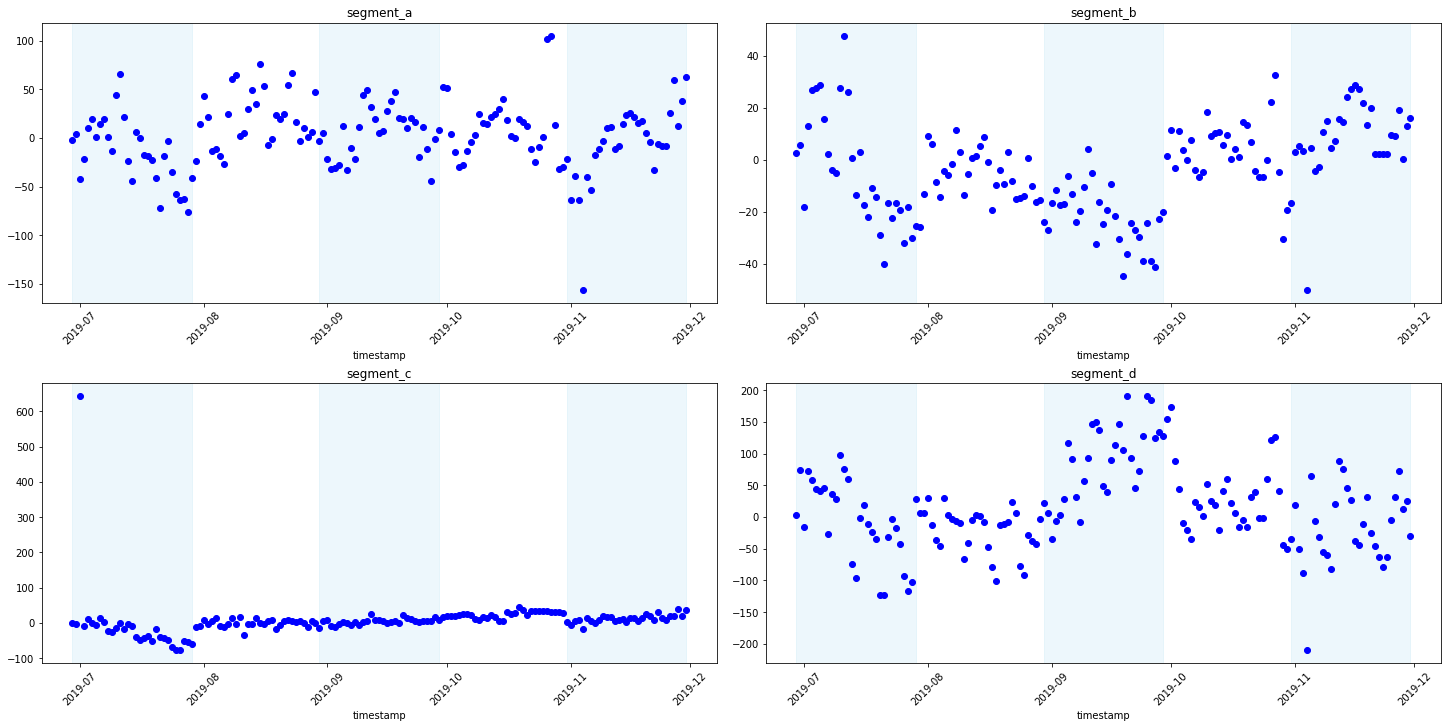

In [28]:
plot_residuals(forecast_df=forecast_df, ts=ts_all)

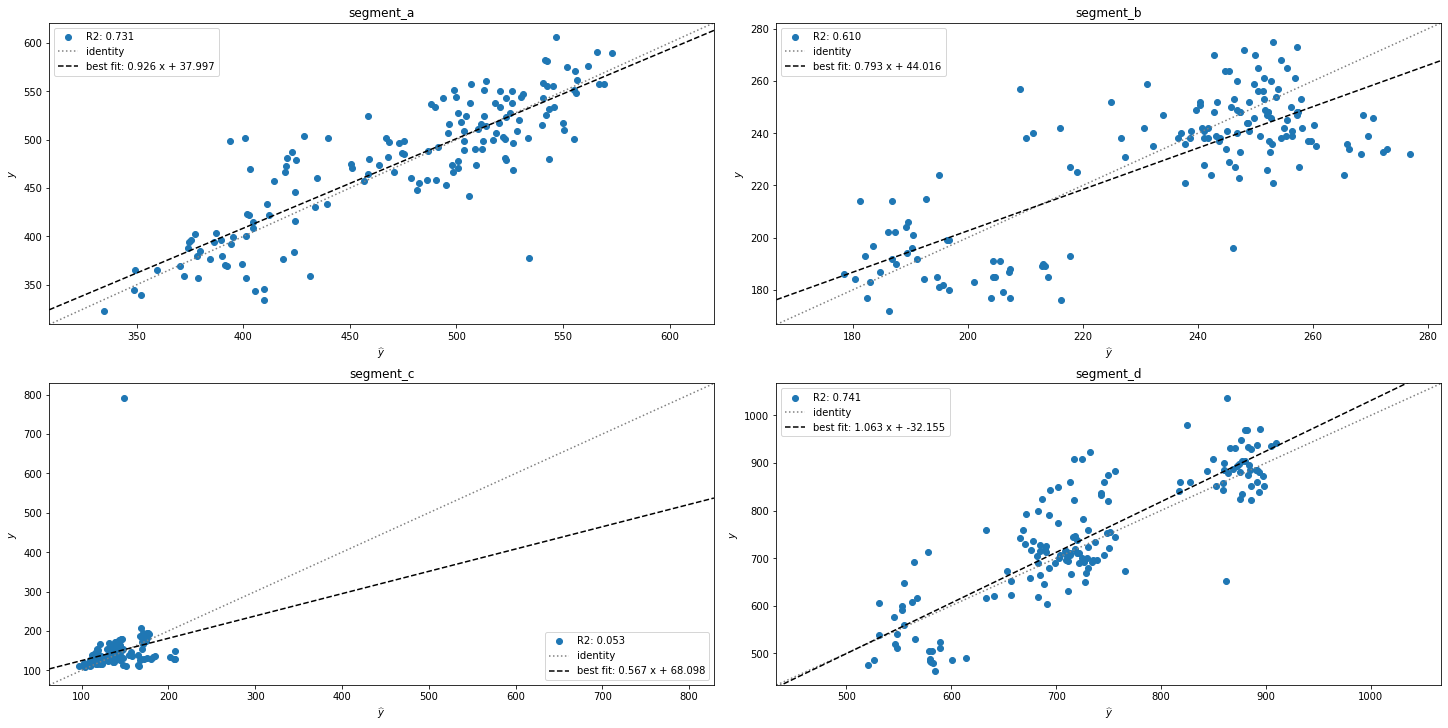

In [29]:
prediction_actual_scatter_plot(forecast_df=forecast_df, ts=ts_all)

That's all for this notebook. More features you can find in our documentation!